In [ ]:
import tensorflow as tf 
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version: "+tf.__version__)

ModuleNotFoundError: No module named 'tensorflow'

In [6]:
import sys
import tensorflow.keras
import tensorflow as tf
import numpy as np

print(f"Tensor Flow Version: {tf.__version__}")
print()
print(f"Python {sys.version}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

2024-02-06 09:58:55.024548: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 09:58:55.024610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 09:58:55.025859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 09:58:55.032978: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 09:58:55.936261: W tensorflow/compiler/tf2

Tensor Flow Version: 2.15.0

Python 3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:33:10) 
[GCC 12.3.0]
GPU is NOT AVAILABLE


2024-02-06 09:58:56.789231: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 09:58:56.839935: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
pip install tensorflow

  Using cached tensorflow-2.15.0.post1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.10.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)
  Using cached libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached ml_dtypes-0.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached numpy-1.26.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached protobuf-4.25.2-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached termcolor-2.4.0-py3

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.applications.vgg16 import VGG16
from tensorflow import keras
from keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv1D



In [10]:
def getProfilSD(profil):
    #Générer des données aléatoires pour le nuage de points
    num_points = len(profil)
    x_values = profil.x
    y_values = profil.y

    # # Créer le nuage de points
    # plt.scatter(x_values, y_values, c='blue', marker='o', label='Nuage de points')

    # Effectuer la régression linéaire
    coefficients = np.polyfit(x_values, y_values, 1)
    polynomial = np.poly1d(coefficients)

    # Tracer la droite de régression linéaire
    x_regression = np.linspace(min(x_values), max(x_values), num_points)

    residuals = y_values -  polynomial(x_regression)
    return np.std(residuals)
                     
def shiftYValues(profil):
    zone1 = profil[(profil.x >= -570) & (profil.x <= -470)]
    zone3 = profil[(profil.x >= 470) & (profil.x <= 570)]

    sd_zone1 = getProfilSD(zone1) if not zone1.empty else None
    sd_zone3 = getProfilSD(zone3) if not zone3.empty else None

    if(sd_zone1 == None):
        xmin = zone3.x.min()
    elif(sd_zone3 == None):
        xmin = zone1.x.min()
    else : 
        xmin = zone3.x.min() if sd_zone3 < sd_zone1 else zone1.x.min()
        
    # print(f"xmin : {xmin} ymin : {profil[profil.x == xmin].y.values[0]}" )
    profil['y'] -= profil.loc[profil['x'] == xmin, 'y'].values[0]
    profil = profil[(profil.x >= -470) & (profil.x <= 470)]
    return profil

# Function to remove outlier from y 
def remove_outliers_from_y(points, min_threshold, max_threshold):
    points.loc[(points.y >= max_threshold) | (points.y <= min_threshold), 'y'] = np.nan
    # outlier_mask = points[(points.y >= max_threshold) | (points.y <= min_threshold)] 
    points.loc[:, 'y'] = points.loc[:, 'y'].ffill()
    points.loc[:, 'y'] = points.loc[:, 'y'].bfill()
    return points

def process_normalization(profil, min, max):
    profil['y'] = (profil.y - min) / (max - min)


# Function to standardize the size of data by adding padding
def pad_to_same_size(data):
    # permet de mettre toutes les données à la même taille.     
       
    max_length = max(len(d) for d in data)
    return [tf.pad(d, paddings=[[0, max_length - len(d)]], mode='SYMMETRIC') if len(d) < max_length else d for d in data]

# Function to process each CSV file
def process_csv_file(file_path):
    min_y = -110
    max_y = 200 
    points = pd.read_csv(file_path, names=['x', 'y'])
    sorted_points = points.sort_values(by='x')
    sorted_points = sorted_points.drop_duplicates()
    # shifted_points = shiftYValues(sorted_points)
    # cleaned_points = remove_outliers_from_y(shifted_points,min_y,max_y)
    sorted_points = sorted_points[(sorted_points.x >= -470) & (sorted_points.x <= 470)]
    # sorted_points.y +=1200
    # sorted_points.y /=10
    
    # process_normalization(cleaned_points,min_y,max_y)
    return sorted_points.y

def load_profiles(src):
    classes_id = [d for d in os.listdir(src) if os.path.isdir(os.path.join(src, d))]
    data = []
    target = []
    for classe_id in classes_id:
        dataset_path = os.path.join(src,classe_id)
        files_path = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith('.csv')]
        for file_path  in files_path: 
            profil_points = process_csv_file(file_path)
            data.append(profil_points)
            target.append(classe_id)
    
    padded_data = pad_to_same_size(data)
    return  Bunch(
         data= np.array(padded_data), 
         target= np.array(target) )


In [11]:
dataset_root = "C:\\Users\\onerf\\Documents\\UMons\\Master2\\Stage\\ballast\\ballast-toolbox\\src\\main\\resources\\template-export\\"
profiles = load_profiles(dataset_root + "sleepers_db\\")
profiles_test = load_profiles(dataset_root + "test\\")

id2int = {v:ix for ix,v in enumerate(np.unique(profiles.target))}
int2id = {v:ix for ix,v in enumerate(np.unique(profiles.target))}

profiles.target = [id2int[val] for val in profiles.target]
profiles_test.target = [id2int[val] for val in profiles_test.target]

In [12]:
x, y = profiles.data, profiles.target
x = x.reshape(x.shape[0],x.shape[1],1)
print(f'x shape : {x.shape}')
x_test, y_test = profiles_test.data, profiles_test.target
x_test= x_test.reshape(x_test.shape[0],x_test.shape[1],1)
print(f'x_test shape : {x_test.shape}')


x shape : (2220, 437, 1)
x_test shape : (400, 437, 1)


In [13]:
def get_model():
    model = Sequential()
    model.add(keras.layers.Conv1D(16,8, activation='relu', input_shape=(437, 1)))
    # model.add(keras.layers.Conv1D(16,8, activation='relu', input_shape=(437, 1)))
    model.add(Flatten())  # Flatten the output from the convolutional layer
    # model.add(keras.layers.Dense(units=256, activation='sigmoid'))  # Assuming 3 classes, adjust based on your task
    model.add(keras.layers.Dense(units=3, activation='softmax'))  # Assuming 3 classes, adjust based on your task
    return model

# batch_size=4 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
# epochs=5 #@param [5, 10,20,50,100,200] {type:"raw"}

# model = get_model()
# model.compile(optimizer=SGD(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# history = model.fit(x, y, epochs=epochs, validation_split=0.2, shuffle=True, batch_size=batch_size)

In [14]:
batch_sizes = [4,8,16,32,64,128] 
n_epochs= [5, 10 ,20,50,100,200] 
dict = {}

for batch_size in batch_sizes:
    dict[batch_size]= {}
    for epoch in n_epochs:
        model = get_model()
        model.compile(optimizer=SGD(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(x, np.array(y), epochs=epoch, validation_split=0.2, shuffle=True, batch_size=batch_size)
        eval = model.evaluate(x_test,np.array(y_test))
        dict[batch_size][epoch] = [history,eval]

Epoch 1/5
444/444 [==============================] - 1s 2ms/step - loss: 61570.2422 - accuracy: 0.4262 - val_loss: 1.5980 - val_accuracy: 0.0000e+00
Epoch 2/5
444/444 [==============================] - 1s 2ms/step - loss: 1.0136 - accuracy: 0.4240 - val_loss: 1.7987 - val_accuracy: 0.0000e+00
Epoch 3/5
444/444 [==============================] - 1s 2ms/step - loss: 1.0100 - accuracy: 0.4178 - val_loss: 1.8726 - val_accuracy: 0.0000e+00
Epoch 4/5
444/444 [==============================] - 1s 2ms/step - loss: 1.0094 - accuracy: 0.4172 - val_loss: 1.8970 - val_accuracy: 0.0000e+00
Epoch 5/5
13/13 [==============================] - 0s 2ms/step - loss: 1.2464 - accuracy: 0.3150
Epoch 1/10
444/444 [==============================] - 1s 3ms/step - loss: 6168.2939 - accuracy: 0.4257 - val_loss: 1.6041 - val_accuracy: 0.0000e+00
Epoch 2/10
444/444 [==============================] - 1s 2ms/step - loss: 1.0136 - accuracy: 0.4071 - val_loss: 1.7960 - val_accuracy: 0.0000e+00
Epoch 3/10
444/444 [====

In [1]:
fig, ax = plt.subplots(len(batch_sizes),2, figsize=(12,14))
fig.tight_layout(pad=3.5)
for idx, batch_size in enumerate(dict.keys()):
    
    keys = list(dict[batch_size].keys())
    loss_elements = [value[1][0] for value in dict[batch_size].values()]
    accuracy_elements = [value[1][1] for value in dict[batch_size].values()]
    ax[idx,0].set_title(f'Batch size {batch_size} ')
    ax[idx,0].set_xlabel('Epoch')
    ax[idx,0].set_ylabel('Loss')
    ax[idx,0].plot(keys, loss_elements, 'r',label='Test Loss')
    
    ax[idx,1].set_title(f'Batch size {batch_size} ')
    ax[idx,1].set_xlabel('Epoch')
    ax[idx,1].set_ylabel('Accuracy')
    ax[idx,1].plot(keys, accuracy_elements, label='Test Accuracy')


NameError: name 'plt' is not defined

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

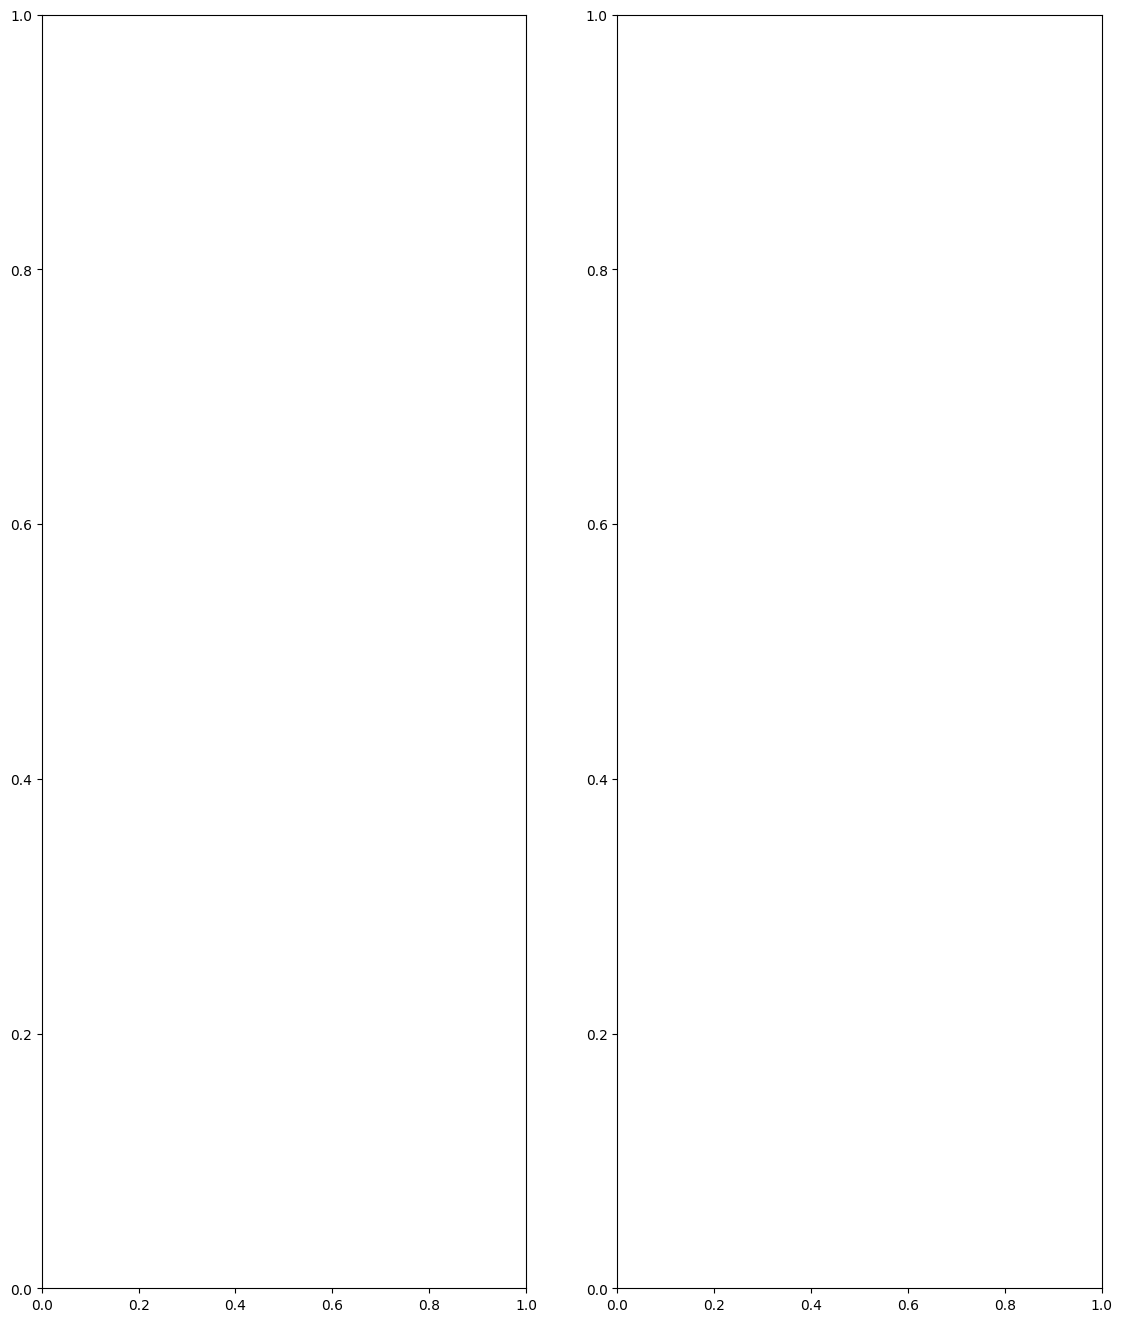

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,14))
fig.tight_layout(pad=3.5)
for epoch in n_epochs: 
    for batch_size in dict.keys():
        
        loss_elements = dict[batch_size][epoch][1][0]
        accuracy_elements = dict[batch_size][epoch][1][1]
        if epoch == 5 :
            idx = (0,0)   
        elif epoch == 10:
            idx = (0,1) 
        elif epoch == 20 :
            idx = (1,0)
        elif epoch ==50: 
            idx = (1,1)
        elif epoch == 100:
            idx = (2,0)
        else :
            idx = (2,1)


        plt.legend()
        ax[idx].set_title(f'Batch size {batch_size} ')
        ax[idx].set_xlabel('Epoch')
        ax[idx].set_ylabel('Loss')
        ax[idx].plot(keys, loss_elements, 'r',label='Test Loss')
        
        ax[idx].set_title(f'Batch size {batch_size} ')
        ax[idx].set_xlabel('Epoch')
        ax[idx].set_ylabel('Accuracy')
        ax[idx].plot(keys, accuracy_elements, label='Test Accuracy')

In [30]:
dict[32][5][1]

[1.1470825672149658, 0.3149999976158142]

In [222]:
headers = ["Batch size","Epochs","LOSS","Accuracy"]
data = {}


textabular = f"|c|c|c|c|"
for batch_size in dict.keys():
   print()



print("\\begin{tabular}{"+textabular+"}")
print("\\end{tabular}")

AttributeError: 'int' object has no attribute 'keys'

In [ ]:
dict[5]

TypeError: 'int' object is not subscriptable

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 430, 16)           144       
                                                                 
 flatten_8 (Flatten)         (None, 6880)              0         
                                                                 
 dense_12 (Dense)            (None, 3)                 20643     
                                                                 
Total params: 20787 (81.20 KB)
Trainable params: 20787 (81.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


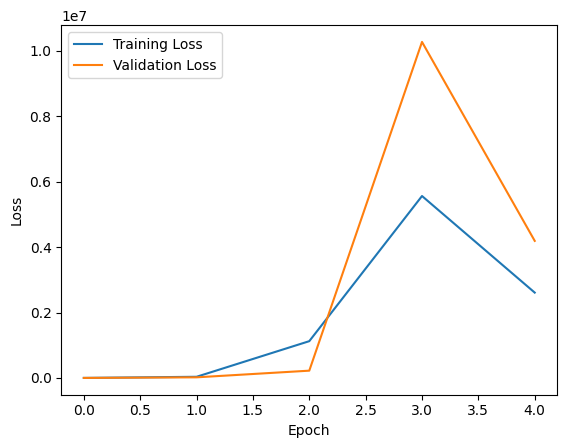

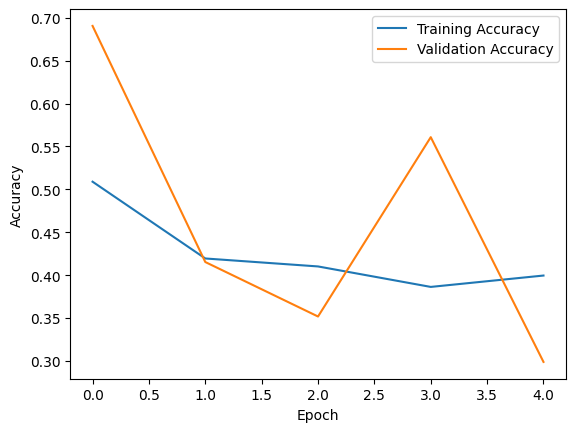

In [ ]:
# Visualisation des courbes d'entraînement/validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
eval = model.evaluate(x_test,y_test)
print(f'Test LOSS : {eval[0]*100:.2f}%, Test Accuracy : {eval[1]*100:.2f}%')


11/11 [==============================] - 0s 2ms/step - loss: 4107.9189 - accuracy: 0.5255
Test LOSS : 410791.89%, Test Accuracy : 52.55%
